<a href="https://colab.research.google.com/github/Nunuy15/Thesis/blob/main/mobilenetv3_dasar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Tahap 1: Inisialisasi Generator Gambar**
Pada tahap ini, kita membuat ImageDataGenerator dan mengatur fungsi preprocessing agar sesuai dengan MobileNetV3.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan ImageDataGenerator dengan fungsi preprocessing MobileNetV3
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

# **Tahap 2: Memuat Gambar dari Direktori**
Pada tahap ini, kita membuat generator gambar (train_generator) untuk menghasilkan gambar dari direktori training. Gambar-gambar ini akan diproses sesuai target size yang ditentukan.

In [ ]:
# Directories
train_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/train'
val_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/valid'
test_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/test'

# Ukuran gambar dan batch size
img_height, img_width = 224, 224
batch_size = 32

# Membuat generator untuk memuat gambar dari direktori
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3570 images belonging to 6 classes.
Found 1020 images belonging to 6 classes.
Found 510 images belonging to 6 classes.


# **Tahap 3: Fungsi untuk Menampilkan Gambar dari Setiap Kelas**
Pada tahap ini, kita membuat fungsi untuk menampilkan satu gambar acak dari setiap kelas dalam batch pertama yang dihasilkan oleh generator.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images_from_each_class(generator, class_names, img_height=224, img_width=224):
    """
    Fungsi untuk menampilkan gambar acak dari setiap kelas dalam generator gambar.

    Parameters:
    - generator: ImageDataGenerator yang telah dikonfigurasi
    - class_names: Daftar nama kelas
    - img_height, img_width: Dimensi gambar
    """
    # Menyimpan gambar acak dari setiap kelas
    random_images = {}

    # Mengambil batch pertama dari generator
    for images, labels in generator:
        for i in range(len(images)):
            label = np.argmax(labels[i])  # Mengambil indeks kelas
            class_name = class_names[label]

            # Simpan satu gambar dari setiap kelas
            if class_name not in random_images:
                random_images[class_name] = images[i]

        # Jika sudah memiliki satu gambar dari setiap kelas, hentikan loop
        if len(random_images) == len(class_names):
            break

    # Visualisasi gambar acak dari setiap kelas
    plt.figure(figsize=(15, 8))
    for i, (class_name, image) in enumerate(random_images.items()):
        ax = plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
    plt.show()

# **Tahap 4: Menjalankan Fungsi dan Menampilkan Hasil**
Pada tahap ini, kita menjalankan fungsi yang telah dibuat untuk menampilkan gambar dari setiap kelas. Kita juga mengambil nama kelas dari train_generator untuk memastikan bahwa setiap kelas tercakup.

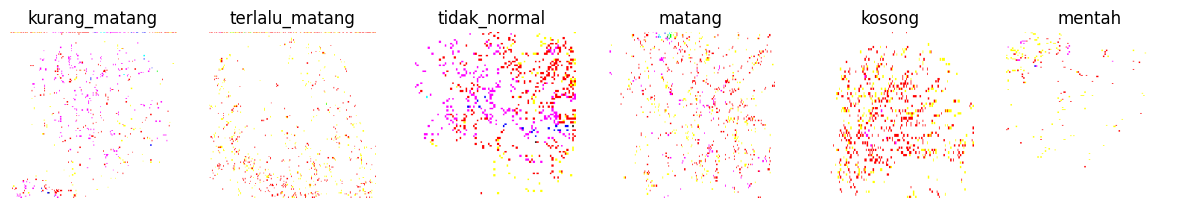

In [ ]:
# Mendapatkan nama kelas dari train_generator
class_names = list(train_generator.class_indices.keys())

# Tampilkan gambar acak dari setiap kelas
show_random_images_from_each_class(train_generator, class_names)

# **Tahap 5: Pembuatan Model**
Pada tahap ini, kita membangun model menggunakan MobileNetV3 sebagai base model, menambahkan beberapa layer tambahan untuk menyesuaikan output dengan jumlah kelas yang diinginkan.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV3 Large model sebagai base model tanpa lapisan klasifikasi teratas
base_model = MobileNetV3Large(
    input_shape=(img_height, img_width, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    dropout_rate=0.2,
    include_preprocessing=True
)

# Membekukan base model untuk transfer learning
base_model.trainable = False

# Menambahkan lapisan custom di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(len(class_names), activation='softmax')(x)  # Sesuaikan output dengan jumlah kelas

# Definisikan model keseluruhan
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Tahap 6: Melatih Model**
Melatih model menggunakan generator data yang telah dikonfigurasi sebelumnya, yaitu `train_generator` dan `val_generator`.

In [ ]:
# Jumlah epoch untuk training
epochs = 100  # Anda bisa menyesuaikan jumlah epoch sesuai kebutuhan

# Melatih model dan menyimpan hasil pelatihan dalam variabel history
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.3251 - loss: 1.7798 - val_accuracy: 0.6059 - val_loss: 1.0321
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6706 - loss: 0.9349 - val_accuracy: 0.6971 - val_loss: 0.8267
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7430 - loss: 0.7435 - val_accuracy: 0.7333 - val_loss: 0.7268
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.7878 - loss: 0.6446 - val_accuracy: 0.7441 - val_loss: 0.6682
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8142 - loss: 0.5790 - val_accuracy: 0.7696 - val_loss: 0.6193
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8242 - loss: 0.5352 - val_accuracy: 0.7716 - val_loss: 0.5956
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8453 - loss: 0.4782 - val_accuracy: 0.7902 - val_loss: 0.5634
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8581 - loss: 0.4385 - val_accuracy

# **Tahap 7: Evaluasi Model**
Melakukan evaluasi pada data test dan menghasilkan laporan klasifikasi serta confusion matrix untuk mengetahui performa model pada data yang belum pernah dilihat.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Prediksi pada data test
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Laporan klasifikasi
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
                precision    recall  f1-score     support
kosong           0.941176  0.941176  0.941176   85.000000
kurang_matang    0.814815  0.776471  0.795181   85.000000
matang           0.852273  0.882353  0.867052   85.000000
mentah           0.920455  0.952941  0.936416   85.000000
terlalu_matang   0.950617  0.905882  0.927711   85.000000
tidak_normal     0.908046  0.929412  0.918605   85.000000
accuracy         0.898039  0.898039  0.898039    0.898039
macro avg        0.897897  0.898039  0.897690  510.000000
weighted avg     0.897897  0.898039  0.897690  510.000000


# **Tahap 8: Visualisasi Hasil Training dan Evaluasi**

# 8.1. Visualisasi Akurasi Training dan Validation
Menampilkan grafik akurasi training dan validation dari hasil pelatihan untuk memantau kinerja model.

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


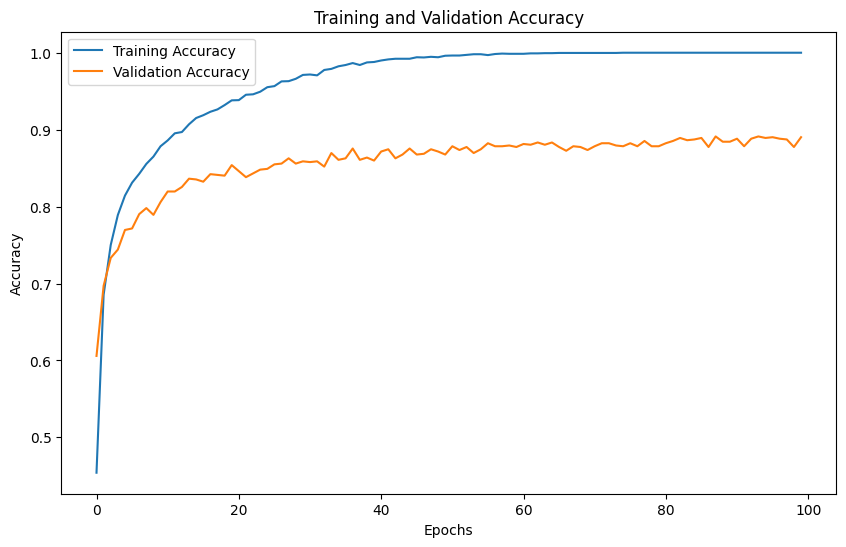

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

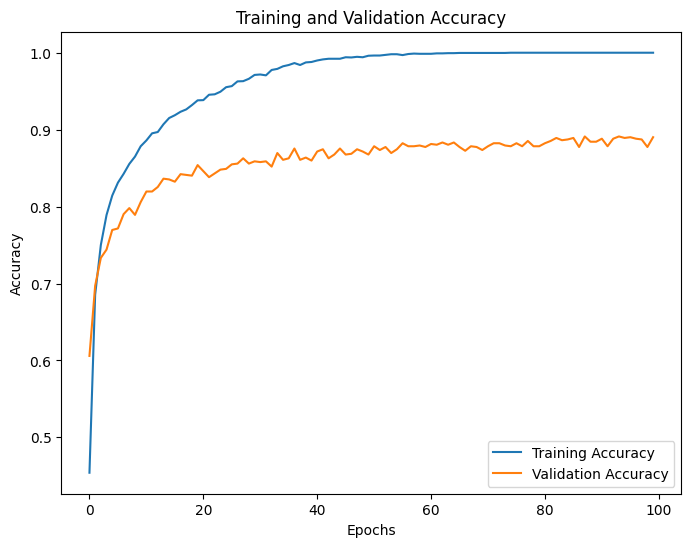

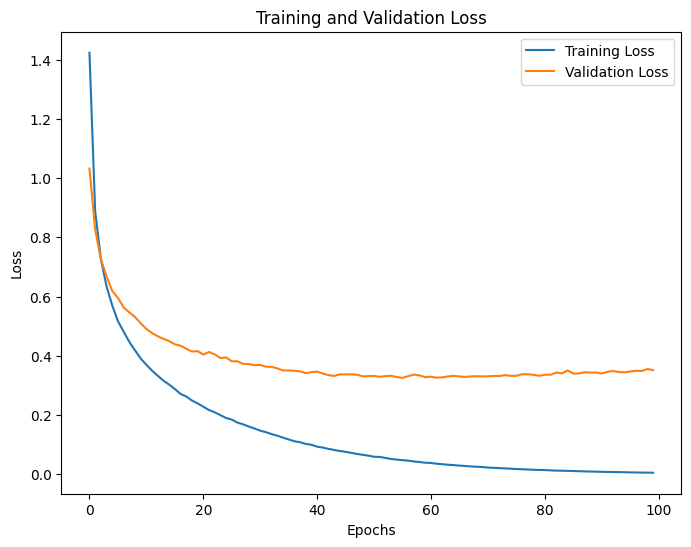

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# 8.2. Visualisasi Precision, Recall, dan F1 Score per Kelas
Menampilkan precision, recall, dan f1-score untuk setiap kelas.

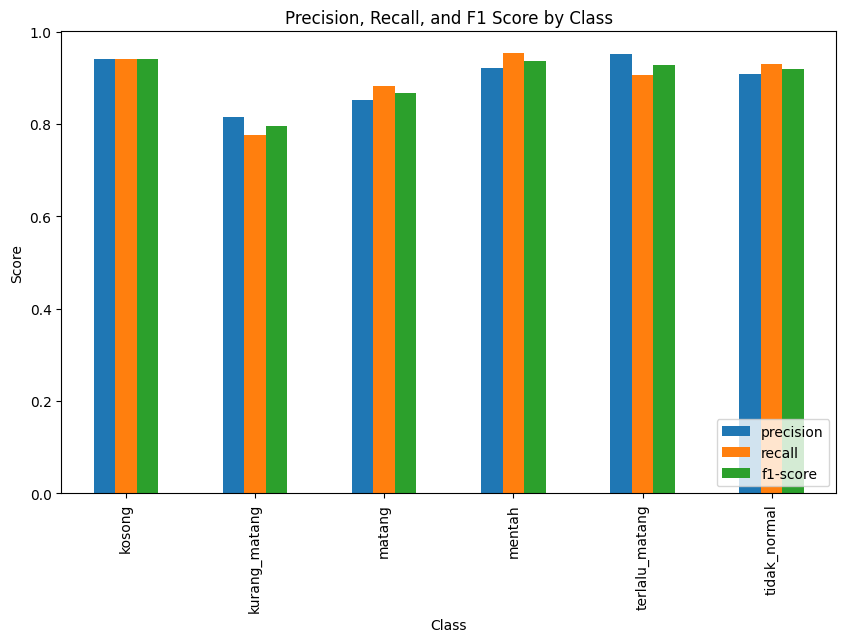

In [ ]:
# Visualisasi precision, recall, dan f1-score per kelas
df_metrics = df_report.loc[class_names, ["precision", "recall", "f1-score"]]
df_metrics.plot(kind="bar", figsize=(10, 6))
plt.title("Precision, Recall, and F1 Score by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.show()

# 8.3. Visualisasi Confusion Matrix
Menampilkan confusion matrix untuk memeriksa kesalahan klasifikasi model pada data test.

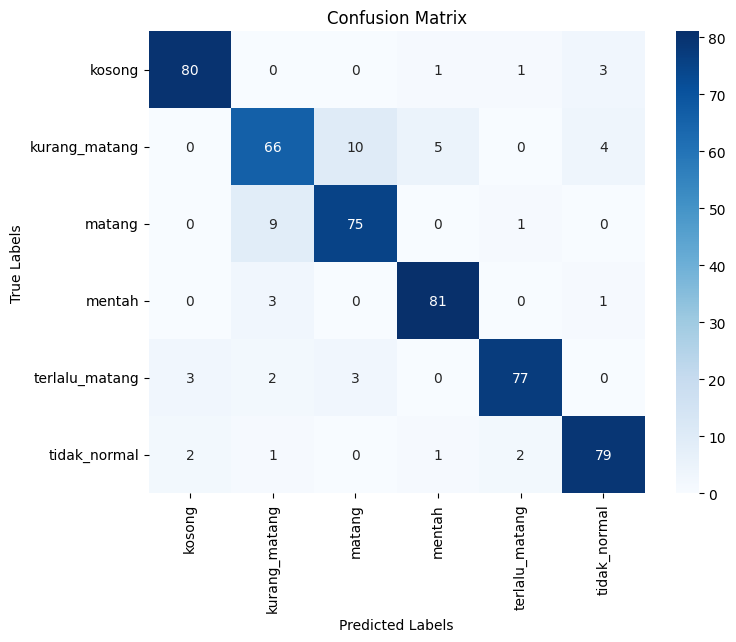

In [ ]:
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Tahap 9: Menyimpan Model**
Simpan model yang telah dilatih untuk digunakan di masa mendatang.

In [ ]:
# Menyimpan model
model.save('/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/saved_model_mobileNetV3Large.keras')

# **HIDE**

In [ ]:
import os
from collections import Counter

dataset_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/'
class_counts = Counter()

for class_dir in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_dir)
    if os.path.isdir(class_path):
        class_counts[class_dir] = len(os.listdir(class_path))

print("Distribusi kelas:", class_counts)


Distribusi kelas: Counter({'train': 6, 'valid': 6, 'test': 6})


In [ ]:
import os
from PIL import Image

def is_image_valid(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verifikasi gambar
        return True
    except (IOError, SyntaxError):
        return False

def check_images_in_folder(root_folder):
    invalid_images = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            image_path = os.path.join(root, file)
            if not is_image_valid(image_path):
                invalid_images.append(file)  # Menambahkan nama file saja
                print(f"Gambar {file} di lokasi {image_path} rusak atau tidak dapat dibaca.")
    return invalid_images

# Contoh penggunaan
root_folder = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/valid'
invalid_images = check_images_in_folder(root_folder)
print(f"Jumlah gambar yang rusak atau tidak dapat dibaca: {len(invalid_images)}")
print("Daftar nama gambar yang rusak:", invalid_images)


Jumlah gambar yang rusak atau tidak dapat dibaca: 0
Daftar nama gambar yang rusak: []


In [ ]:
import os

# Path folder utama untuk dataset
dataset_folder = "/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN"
subfolders = ["train", "valid", "test"]

# Dictionary untuk menyimpan jumlah gambar per kelas di setiap subfolder dataset
dataset_counts = {subfolder: {} for subfolder in subfolders}

# Loop untuk setiap subfolder dataset (Training, Testing, Validasi)
for subfolder in subfolders:
    # Path ke folder dataset spesifik (misal, TRAINING, TESTING, VALIDASI)
    subfolder_path = os.path.join(dataset_folder, subfolder)

    # Cek apakah folder ada
    if not os.path.exists(subfolder_path):
        print(f"Folder '{subfolder_path}' tidak ditemukan, melewati...")
        continue

    # Loop untuk setiap folder label dalam subfolder (misal, label_0, label_1, dst.)
    for label_folder in os.listdir(subfolder_path):
        label_path = os.path.join(subfolder_path, label_folder)

        if os.path.isdir(label_path):  # Pastikan hanya menghitung folder
            # Hitung jumlah file gambar dalam folder label
            num_files = len([file for file in os.listdir(label_path) if file.endswith(".jpg")])
            # Simpan jumlah ke dalam dictionary
            dataset_counts[subfolder][label_folder] = num_files

# Tampilkan hasil
for subfolder, counts in dataset_counts.items():
    print(f"\nJumlah gambar di folder '{subfolder}':")
    for label, count in counts.items():
        print(f"  {label}: {count} gambar")
    print(f"Total gambar di {subfolder}: {sum(counts.values())}")

print("\nPerhitungan selesai.")


Jumlah gambar di folder 'train':
  label_5: 595 gambar
  label_3: 595 gambar
  label_2: 595 gambar
  label_1: 595 gambar
  label_0: 595 gambar
  label_4: 595 gambar
Total gambar di train: 3570

Jumlah gambar di folder 'valid':
  label_5: 170 gambar
  label_3: 170 gambar
  label_2: 170 gambar
  label_1: 170 gambar
  label_0: 170 gambar
  label_4: 170 gambar
Total gambar di valid: 1020

Jumlah gambar di folder 'test':
  label_5: 85 gambar
  label_3: 85 gambar
  label_2: 85 gambar
  label_1: 85 gambar
  label_0: 85 gambar
  label_4: 85 gambar
Total gambar di test: 510

Perhitungan selesai.


In [ ]:
import os
import shutil
import random

# Tentukan path asal dan tujuan
src_folder = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/train/label_0'
dst_folder = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN_SISA/train/label_0'

# Pastikan direktori tujuan ada, jika tidak ada maka dibuat
os.makedirs(dst_folder, exist_ok=True)

# Ambil semua file dari folder sumber, lalu pilih 84 file secara acak
all_files = os.listdir(src_folder)
files = random.sample(all_files, 7)

# Pindahkan file ke folder tujuan
for file_name in files:
    src_path = os.path.join(src_folder, file_name)
    dst_path = os.path.join(dst_folder, file_name)
    shutil.move(src_path, dst_path)

print("7 gambar acak berhasil dipindahkan.")

1 gambar acak berhasil dipindahkan.


In [ ]:
import os
import shutil
from PIL import Image

# Tentukan path asal dan tujuan
src_folder = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/train/label_5'
dst_folder = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN_SISA/train/label_5'

# Pastikan direktori tujuan ada, jika tidak ada maka dibuat
os.makedirs(dst_folder, exist_ok=True)

# Buat list untuk menyimpan resolusi dan nama file
files_with_resolutions = []

# Loop melalui file untuk mengumpulkan resolusi
for file_name in os.listdir(src_folder):
    src_path = os.path.join(src_folder, file_name)
    try:
        # Buka gambar dan dapatkan resolusinya
        with Image.open(src_path) as img:
            width, height = img.size
            resolution = width * height  # Menghitung resolusi sebagai area (width * height)
            files_with_resolutions.append((resolution, file_name))
    except Exception as e:
        print(f"Gagal memproses {file_name}: {e}")

# Urutkan daftar berdasarkan resolusi terkecil terlebih dahulu
files_with_resolutions.sort(key=lambda x: x[0])

# Ambil 7 file dengan resolusi terkecil
files_to_move = [file[1] for file in files_with_resolutions[:7]]

# Pindahkan file ke folder tujuan
for file_name in files_to_move:
    src_path = os.path.join(src_folder, file_name)
    dst_path = os.path.join(dst_folder, file_name)
    shutil.move(src_path, dst_path)

print("7 gambar dengan resolusi terkecil berhasil dipindahkan.")

7 gambar dengan resolusi terkecil berhasil dipindahkan.
